In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import re
from scipy.stats import ttest_rel as paired_ttest
import sys
import os
import tqdm 

import seaborn as sns

from dotenv import load_dotenv
load_dotenv()

True

In [7]:
import sys
sys.path.insert(0, "/home/mohanty/food/fay-data-aggregator-v1")

from db_helpers import database as db
from db_helpers import data_sources as ds

h = ds.Helper.human_readable_number

# pip install psycopg2-binary

In [8]:
ids = {}

In [9]:
completed_participants = db.AnalyticsDb().select("""
    SELECT id, cohort
    FROM faydesc_participants
    WHERE phase = '4_study_end'
""")


In [10]:
mfr_data = ds.Data.get_dishes()

mask = mfr_data["fay_user_id"].isin(completed_participants["id"])
completed_mfr_data = mfr_data[mask].copy()

# completed_mfr_data = mfr_data


/home/mohanty/food/fay-data-aggregator-v1/db_helpers/cache mfr_data_v1.csv


In [11]:
# results dishes and kcal
print("Num dishes:  ", end="")
res = h(completed_mfr_data["dish_id"].nunique())
ids["results_dishes_completed"] = res
print(res)

print("Sum of kcal: ", end="")
res = h(completed_mfr_data["energy_kcal_eaten"].sum())
ids["results_kcal_completed"] = res
print(res)


Num dishes:  223'829
Sum of kcal: 32'428'539.62


In [12]:
# Special food consumption

tag_ids = {"meal": 3240, "drink": 3080}
df = completed_mfr_data
print("Num standard breakfasts: ", end="")
res = h(df[df["food_id"] == tag_ids["meal"]]["dish_id"].nunique())
ids["results_standard_breakfasts"] = res
print(res)

print("Num glucose drinks:      ", end="")
res = h(df[df["food_id"] == tag_ids["drink"]]["dish_id"].nunique())
ids["results_glucose_drinks"] = res
print(res)


Num standard breakfasts: 6'847
Num glucose drinks:      2'137


In [23]:
# abstract_stool_samples
participant_ids_with_mb_data = db.AnalyticsDb().select_col("""
    SELECT DISTINCT p.id
    FROM microbiome_json_otu mb
    JOIN faydesc_participants p ON p.mbtube_admin = mb.fk_userid
""")
res = h(len(participant_ids_with_mb_data))
ids["abstract_stool_samples"] = res
print(res)


1'024


In [15]:
users = db.AnalyticsDb().select("""
    SELECT
        id AS user_id,
        cohort
    FROM faydesc_participants
    WHERE phase = '4_study_end'
""")
subjective_pa_counts = db.FayDb().select("""
    SELECT
        es.user_id,
        COUNT(*) AS num_subjective_pa
    FROM evening_surveys es
    JOIN physical_activities pa ON pa.evening_survey_id = es.id
    GROUP BY es.user_id
""")
objective_pa_instances = db.AnalyticsDb().select("""
    SELECT
        pa.user_id_fk AS user_id,
        MIN(pa.activity ORDER BY CASE WHEN pa.activity = 'other' THEN 1 ELSE -1 END) AS activity
    FROM pa_activity pa
    WHERE
        start_date NOTNULL AND
        stop_date NOTNULL
    GROUP BY
        pa.user_id_fk,
        pa.start_date,
        pa.stop_date
""")


In [16]:
objective_pa_counts = objective_pa_instances.groupby("user_id").agg(num_objective_pa=("activity", "count")).reset_index()


In [19]:
df = users.merge(subjective_pa_counts, on="user_id", how="left")
df = df.merge(objective_pa_counts, on="user_id", how="left")
df["num_subjective_pa"] = df["num_subjective_pa"].fillna(0).astype(int)
df["num_objective_pa"] = df["num_objective_pa"].fillna(0).astype(int)
raw = df.copy()

grouped = df.groupby("cohort")
num_users_total = grouped["user_id"].nunique()
num_users_with_subjective_pa = grouped.apply(lambda x: (x["num_subjective_pa"] > 0).sum())
num_users_with_objective_pa = grouped.apply(lambda x: (x["num_objective_pa"] > 0).sum())
num_users_with_any_pa = grouped.apply(lambda x: ((x["num_subjective_pa"] > 0) | (x["num_objective_pa"] > 0)).sum())
num_users_with_both_pa = grouped.apply(lambda x: ((x["num_subjective_pa"] > 0) & (x["num_objective_pa"] > 0)).sum())
processed = pd.DataFrame({
    "cohort": num_users_total.index,
    "total": num_users_total.values,
    "subj": num_users_with_subjective_pa.values,
    "obj": num_users_with_objective_pa.values,
    "any": num_users_with_any_pa.values,
    "both": num_users_with_both_pa.values,
})
processed["none"] = processed["total"] - processed["any"]
processed["none%"] = (100.0 * processed["none"] / processed["total"]).round(2)
processed["subj_of_any%"] = (100.0 * processed["subj"] / processed["any"]).round(2)
processed.reset_index(drop=True, inplace=True)

print(f"Subjective entries: {h(raw['num_subjective_pa'].sum())}")
print(f"Objective entries:  {h(raw['num_objective_pa'].sum())}\n")
print(processed.to_string(index=False))


Subjective entries: 6'460
Objective entries:  28'474

cohort  total  subj  obj  any  both  none  none%  subj_of_any%
     B    870   382  204  583     3   287  32.99         65.52
     C    144    60   24   83     1    61  42.36         72.29


/tmp/ipykernel_2208725/389709101.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  num_users_with_subjective_pa = grouped.apply(lambda x: (x["num_subjective_pa"] > 0).sum())
/tmp/ipykernel_2208725/389709101.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  num_users_with_objective_pa = grouped.apply(lambda x: (x["num_objective_pa"] > 0).sum())
/tmp/ipykernel_2208725/389709101.py:11: DeprecationWarning:

In [20]:
ids["results_PA"] = h(raw["num_subjective_pa"].sum())

res = processed[["cohort", "none%"]].to_string(index=False, header=False)
ids["results_proportion_no_PA"] = res.replace("\n", "%, ") + "%"

res = processed[["cohort", "subj_of_any%"]].to_string(index=False, header=False)
ids["results_percentage_PA_via_survey"] = res.replace("\n", "%, ") + "%"


In [21]:
df = objective_pa_instances.merge(users, on="user_id")
df["activity"] = df["activity"].replace(
    ["gehen", "marche à pied", "camminata", "marche", "spazieren gehen", "randonnée", "hiking", "wandern"],
    "walking"
)
df["activity"] = df["activity"].replace(
    ["laufen", "course à pied", "course", "corsa", "trailrunning", "treadmill_running", "laufbandtraining", "treadmill running", "indoor_running", "course à pied urbaine", "laufen auf der bahn", "trail", "trail_running"],
    "running"
)
df["activity"] = df["activity"].replace(
    ["radfahren", "cyclisme", "virtuelles radfahren", "indoor_cycling", "indoor cycling", "mountain biking", "vélo d'intérieur", "cyclisme sur route", "vtt", "mountainbiken", "gravel bike", "rennradfahren", "virtual cycling", "road cycling"],
    "cycling"
)
res = (100.0 * (df["activity"].isin(["walking", "running", "cycling"])).sum() / len(df)).round(2)
ids["results_walking_running_cycling_percentage"] = res
print(res)


66.55


In [24]:
res = h(participant_ids_with_mb_data.isin(completed_participants["id"]).sum())
ids["results_participants_with_stool_sample"] = res
print(res)


997


In [26]:
# Sleep

sleep = ds.Data.get_sleep()

In [31]:
len(sleep["user_id"].unique())

649

In [48]:
objective_pa_instances = db.AnalyticsDb().select("""
    SELECT * FROM pa_activity pa
    WHERE
        start_date NOTNULL AND
        stop_date NOTNULL
""").rename(columns={"user_id_fk": "user_id"})

In [49]:
objective_pa_instances

,user_id,activity,start_date,stop_date,intensity,distance,altitude_gain,altitude_loss,calories_burned,average_hr,max_hr,source,created_at,updated_at,deleted_at
0,1066,laufen,2020-12-20 14:16:44+00:00,2020-12-20 14:58:35+00:00,None,7.09,115.0,113.0,346.0,162.0,189.0,File,2021-04-23 19:02:40.551127+00:00,2021-04-23 19:02:40.552327+00:00,None
1,1066,sonstige,2020-12-19 15:34:54+00:00,2020-12-19 16:53:20+00:00,None,0.00,NaN,NaN,255.0,109.0,174.0,File,2021-04-23 19:02:40.551137+00:00,2021-04-23 19:02:40.552335+00:00,None
2,1066,laufen,2020-12-18 14:40:54+00:00,2020-12-18 15:09:31+00:00,None,5.06,36.0,26.0,244.0,171.0,187.0,File,2021-04-23 19:02:40.551141+00:00,2021-04-23 19:02:40.552339+00:00,None
3,1066,krafttraining,2020-12-16 19:20:52+00:00,2020-12-16 19:49:56+00:00,None,0.00,NaN,NaN,104.0,106.0,184.0,File,2021-04-23 19:02:40.551145+00:00,2021-04-23 19:02:40.552342+00:00,None
4,1066,krafttraining,2020-12-15 18:37:01+00:00,2020-12-15 19:10:42+00:00,None,0.00,NaN,NaN,142.0,115.0,171.0,File,2021-04-23 19:02:40.551149+00:00,2021-04-23 19:02:40.552345+00:00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30565,2324,cycling,2018-09-11 16:39:39+00:00,2018-09-11 17:24:29+00:00,None,5.18,NaN,NaN,260.0,129.0,168.0,File,2023-04-05 12:50:00.486140+00:00,2023-04-05 12:50:00.486548+00:00,None
30566,2324,running,2018-09-11 14:50:55+00:00,2018-09-11 16:31:46+00:00,None,5.15,NaN,NaN,481.0,127.0,173.0,File,2023-04-05 12:50:00.486140+00:00,2023-04-05 12:50:00.486548+00:00,None
30567,2324,cycling,2018-09-10 15:53:03+00:00,2018-09-10 16:27:07+00:00,None,5.02,NaN,NaN,226.0,134.0,173.0,File,2023-04-05 12:50:00.486141+00:00,2023-04-05 12:50:00.486549+00:00,None
30568,2324,cycling,2018-09-10 08:14:11+00:00,2018-09-10 08:30:16+00:00,None,2.52,NaN,NaN,115.0,137.0,161.0,File,2023-04-05 12:50:00.486141+00:00,2023-04-05 12:50:00.486549+00:00,None


In [50]:
activity_df = objective_pa_instances.merge(users, on="user_id")
activity_df["activity"] = activity_df["activity"].replace(
    ["gehen", "marche à pied", "camminata", "marche", "spazieren gehen", "randonnée", "hiking", "wandern"],
    "walking"
)
activity_df["activity"] = activity_df["activity"].replace(
    ["laufen", "course à pied", "course", "corsa", "trailrunning", "treadmill_running", "laufbandtraining", "treadmill running", "indoor_running", "course à pied urbaine", "laufen auf der bahn", "trail", "trail_running"],
    "running"
)
activity_df["activity"] = activity_df["activity"].replace(
    ["radfahren", "cyclisme", "virtuelles radfahren", "indoor_cycling", "indoor cycling", "mountain biking", "vélo d'intérieur", "cyclisme sur route", "vtt", "mountainbiken", "gravel bike", "rennradfahren", "virtual cycling", "road cycling"],
    "cycling"
)
res = (100.0 * (activity_df["activity"].isin(["walking", "running", "cycling"])).sum() / len(df)).round(2)
ids["results_walking_running_cycling_percentage"] = res
print(res)

70.13


In [58]:
dict(objective_pa_instances["activity"].value_counts())


{'walking': np.int64(8630),
 'running': np.int64(5974),
 'cycling': np.int64(3612),
 'traditionalstrengthtraining': np.int64(1924),
 'other': np.int64(1246),
 'highintensityintervaltraining': np.int64(1145),
 'crosstraining': np.int64(803),
 'mixedcardio': np.int64(737),
 'yoga': np.int64(700),
 'functionalstrengthtraining': np.int64(642),
 'hiking': np.int64(534),
 'swimming': np.int64(437),
 'laufen': np.int64(391),
 'elliptical': np.int64(307),
 'snowsports': np.int64(236),
 'gehen': np.int64(220),
 'climbing': np.int64(197),
 'basketball': np.int64(184),
 'coretraining': np.int64(153),
 'rowing': np.int64(147),
 'radfahren': np.int64(119),
 'downhillskiing': np.int64(108),
 'indoor cycling': np.int64(108),
 'marche à pied': np.int64(107),
 'tennis': np.int64(101),
 'cardiodance': np.int64(99),
 'course à pied': np.int64(93),
 'pilates': np.int64(82),
 'cardio': np.int64(76),
 'mixedmetaboliccardiotraining': np.int64(71),
 'flexibility': np.int64(65),
 'krafttraining': np.int64(65),

In [67]:
# Intensity-based grouping into four categories
activity_groups = {
    "Low": [
        # Typically low intensity or recovery activities:
        "walking", "gehen", "marche à pied", "spazieren gehen", "camminata", "marche",
        "yoga", "pilates", "flexibility", "mindandbody", "taichi",
        "other", "sonstige", "autre", "cooldown", "preparationandrecovery", 
        "atemübung", "fitnessgaming", "chronomètre", "incident detected", "exercice de respiration",
        # Leisurely hiking:
        "hiking", "wandern", "randonnée", "bergsteigen", "alpinisme",
        # Misc
        "equestriansports", 
    ],
    "Moderate": [
        # Moderate-intensity activities:
        # Examples of moderate pace running (or brisk walking alternatives if available)
        "running", "laufen", "course à pied", "course",
        "trailrunning", "treadmill_running", "treadmill running", "indoor_running",
        "corsa", "trail running", "trail_running", "course à pied urbaine", "laufen auf der bahn",
        "course à pied sur tapis roulant", "trail",
        # Moderate cycling variants (assuming a moderate pace)
        "cycling", "radfahren", "indoor cycling", "virtuelles radfahren", "cyclisme",
        "cyclisme sur route", "mountainbiken", "mountain biking", "virtual cycling",
        "vélo d'intérieur", "vtt", "rennradfahren", "e-mountainbike-fahren", "gravel bike",
        "road cycling", "ebiking", "gravel/offroad-radfahren",
        # Routine strength training
        "traditionalstrengthtraining", "functionalstrengthtraining", "coretraining", 
        "krafttraining", "musculation", "strength training",
        # Moderate sports
        "swimming", "pool swimming", "lap_swimming", "schwimmbadschwimmen", 
        "nuoto in piscina", "en piscine", "open water swimming", "open_water_swimming",
        "waterfitness", "schwimmen",
        # Team sports at moderate intensity
        "basketball", "tennis", "volleyball", "badminton", "tabletennis", "squash"
        # Misc
        "skatingsports", "skating", "inlineskaten", 
        "dance", 
    ],
    "High": [
        # High-intensity activities:
        # These typically push cardiovascular limits.
        "highintensityintervaltraining", "crosstraining", "mixedcardio", "elliptical",
        "cardio", "mixedmetaboliccardiotraining", "indoor_cardio", "jumprope", "stairclimbing",
        "stepper", "hiit", "cardiodance", "boxing", "kickboxing",  "gymnastics", 
        # Vigorous skiing or snow sports
        "snowsports", "downhillskiing", "crosscountryskiing", "skifahren/snowboarden",
        "klassischer langlauf", "resort skiing/snowboarding", "langlauf freistil",
        "ski de randonnée nordique/surf des neiges", "backcountry skiing/snowboarding",
        "ski de fond skating", "ski sur piste/surf des neiges", "snowboarding",
        "cross country classic skiing", "snowshoeing", "cross country skate skiing",
        "ski-/snowboardtour",
        # Vigorous rowing or water/paddle sports
        "rowing", "rudern", "rudermaschine", "indoor rowing",
        "sailing", "paddlesports", "stand up paddleboarding", "stand-up-paddle-boarding",
        "watersports", "surfingsports", "surfen", "windsurfing", "kayaking"
        # Misc
        "multi_sport", "multisport"
    ],
}


# Create an inverse mapping: for each activity, assign its group name.
activity_to_group = {}
for group, activities in activity_groups.items():
    for act in activities:
        activity_to_group[act] = group

# Now, assuming your DataFrame is named objective_pa_instances and the column is named "activity":
# You can create a new column with the group names:
objective_pa_instances["activity_intensity_inferred"] = objective_pa_instances["activity"].map(activity_to_group)
objective_pa_instances["activity_intensity_inferred"].value_counts()


activity_group
Moderate    14242
Low         11825
High         4177
Name: count, dtype: int64

In [68]:
objective_pa_instances

,user_id,activity,start_date,stop_date,intensity,distance,altitude_gain,altitude_loss,calories_burned,average_hr,max_hr,source,created_at,updated_at,deleted_at,activity_group
0,1066,laufen,2020-12-20 14:16:44+00:00,2020-12-20 14:58:35+00:00,None,7.09,115.0,113.0,346.0,162.0,189.0,File,2021-04-23 19:02:40.551127+00:00,2021-04-23 19:02:40.552327+00:00,None,Moderate
1,1066,sonstige,2020-12-19 15:34:54+00:00,2020-12-19 16:53:20+00:00,None,0.00,NaN,NaN,255.0,109.0,174.0,File,2021-04-23 19:02:40.551137+00:00,2021-04-23 19:02:40.552335+00:00,None,Low
2,1066,laufen,2020-12-18 14:40:54+00:00,2020-12-18 15:09:31+00:00,None,5.06,36.0,26.0,244.0,171.0,187.0,File,2021-04-23 19:02:40.551141+00:00,2021-04-23 19:02:40.552339+00:00,None,Moderate
3,1066,krafttraining,2020-12-16 19:20:52+00:00,2020-12-16 19:49:56+00:00,None,0.00,NaN,NaN,104.0,106.0,184.0,File,2021-04-23 19:02:40.551145+00:00,2021-04-23 19:02:40.552342+00:00,None,Moderate
4,1066,krafttraining,2020-12-15 18:37:01+00:00,2020-12-15 19:10:42+00:00,None,0.00,NaN,NaN,142.0,115.0,171.0,File,2021-04-23 19:02:40.551149+00:00,2021-04-23 19:02:40.552345+00:00,None,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30565,2324,cycling,2018-09-11 16:39:39+00:00,2018-09-11 17:24:29+00:00,None,5.18,NaN,NaN,260.0,129.0,168.0,File,2023-04-05 12:50:00.486140+00:00,2023-04-05 12:50:00.486548+00:00,None,Moderate
30566,2324,running,2018-09-11 14:50:55+00:00,2018-09-11 16:31:46+00:00,None,5.15,NaN,NaN,481.0,127.0,173.0,File,2023-04-05 12:50:00.486140+00:00,2023-04-05 12:50:00.486548+00:00,None,Moderate
30567,2324,cycling,2018-09-10 15:53:03+00:00,2018-09-10 16:27:07+00:00,None,5.02,NaN,NaN,226.0,134.0,173.0,File,2023-04-05 12:50:00.486141+00:00,2023-04-05 12:50:00.486549+00:00,None,Moderate
30568,2324,cycling,2018-09-10 08:14:11+00:00,2018-09-10 08:30:16+00:00,None,2.52,NaN,NaN,115.0,137.0,161.0,File,2023-04-05 12:50:00.486141+00:00,2023-04-05 12:50:00.486549+00:00,None,Moderate


# Data Aggregation Begins 

,user_id,cohort
0,5,B
1,9,B
2,11,B
3,12,B
4,13,B
...,...,...
1009,2680,B
1010,2682,B
1011,2684,B
1012,2689,B


In [8]:
# Completed Participants

completed_participants = db.AnalyticsDb().select("""
    SELECT id, cohort
    FROM faydesc_participants
    WHERE phase = '4_study_end'
""")

In [9]:
mfr_data = ds.Data.get_dishes()

mask = mfr_data["fay_user_id"].isin(completed_participants["id"])
completed_mfr_data = mfr_data[mask].copy()


In [ ]:
completed_mfr_data

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,food_group_cname,type,display_name_en,...,protein_eaten,fiber_eaten,alcohol_eaten,fay_user_id,cohort,loc_eaten_hour,loc_eaten_on,loc_eaten_dow,loc_eaten_dow_type,loc_eaten_season
21058,1020,<NA>,165,50.0,g,02ae3856ca04,2018-10-31 11:31:50+00:00,vegetables_fruits,generic,Coleslaw (chopped without sauce),...,0.500,NaN,NaN,5,B,12.530556,2018-10-31,Wed,weekday,Fall
25196,1026,<NA>,165,50.0,g,02ae3856ca04,2018-10-31 11:31:50+00:00,vegetables_fruits,generic,Mixed salad (chopped without sauce),...,0.705,0.660,NaN,5,B,12.530556,2018-10-31,Wed,weekday,Fall
49474,1069,<NA>,165,20.0,g,02ae3856ca04,2018-10-31 11:31:50+00:00,vegetables_fruits,generic,"Tomato, raw",...,0.160,0.240,0.0,5,B,12.530556,2018-10-31,Wed,weekday,Fall
119717,1229,<NA>,165,80.0,g,02ae3856ca04,2018-10-31 11:31:50+00:00,vegetables_fruits,generic,Black olives,...,0.720,3.440,0.0,5,B,12.530556,2018-10-31,Wed,weekday,Fall
156091,1455,<NA>,165,80.0,g,02ae3856ca04,2018-10-31 11:31:50+00:00,grains_potatoes_pulses,generic,Couscous,...,1.600,0.880,0.0,5,B,12.530556,2018-10-31,Wed,weekday,Fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248439,2099,<NA>,420073,20.0,g,49tzjt,2023-02-12 06:56:05+00:00,sweets_salty_snacks_alcohol,generic,Jam,...,0.058,0.182,0.0,2691,B,7.934722,2023-02-12,Sun,weekend,Winter
289220,2504,<NA>,420074,100.0,ml,49tzjt,2023-02-12 06:56:42+00:00,non_alcoholic_beverages,generic,"Espresso, with caffeine",...,0.100,0.100,0.0,2691,B,7.945000,2023-02-12,Sun,weekend,Winter
65680,1084,<NA>,420170,100.0,g,49tzjt,2023-02-12 11:16:07+00:00,vegetables_fruits,generic,Cauliflower,...,2.500,2.500,0.0,2691,B,12.268611,2023-02-12,Sun,weekend,Winter
168924,1513,<NA>,420170,150.0,g,49tzjt,2023-02-12 11:16:07+00:00,grains_potatoes_pulses,generic,"Pasta, wholemeal",...,22.500,12.000,NaN,2691,B,12.268611,2023-02-12,Sun,weekend,Winter


In [11]:
completed_mfr_data.columns

Index(['food_id', 'barcode', 'dish_id', 'eaten_quantity', 'eaten_unit',
       'subject_key', 'eaten_at', 'food_group_cname', 'type',
       'display_name_en', 'fallback_food_id', 'eaten_quantity_in_gram',
       'energy_kcal_eaten', 'carb_eaten', 'fat_eaten', 'protein_eaten',
       'fiber_eaten', 'alcohol_eaten', 'fay_user_id', 'cohort',
       'loc_eaten_hour', 'loc_eaten_on', 'loc_eaten_dow', 'loc_eaten_dow_type',
       'loc_eaten_season'],
      dtype='object')

In [12]:
all_participants = set([int(x) for x in completed_mfr_data["fay_user_id"].tolist() ])

# Glucose Data

In [22]:
glucose_q = ds.Data.get_glucose_query()
res = db.AnalyticsDb().select(
    q=f"SELECT g.* FROM ({glucose_q.text}) g",
    p=glucose_q.parameters,
    i=glucose_q.identifiers
)

glucose_readings = res


In [17]:
all_users = list(res["user_id"].unique())

In [27]:
user_slice = res[res["user_id"].isin(all_users)]

In [28]:
user_slice["val"]

0          6.06
1          7.55
2          8.51
3          7.39
4          6.80
           ... 
1470025    4.60
1470026    4.70
1470027    4.90
1470028    5.10
1470029    5.20
Name: val, Length: 1470030, dtype: float64

<Axes: xlabel='loc_read_at', ylabel='val'>

/home/mohanty/micromamba/envs/ppgr/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/mohanty/micromamba/envs/ppgr/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


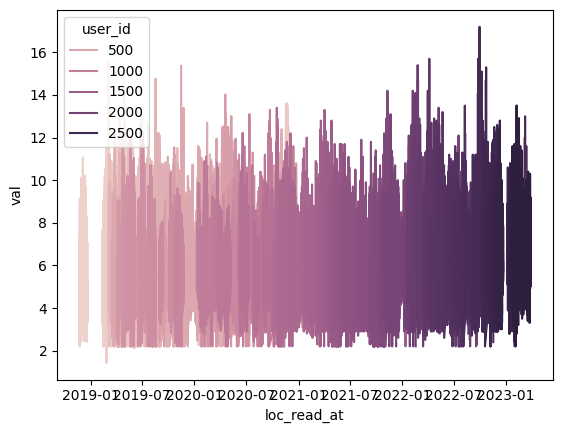

In [29]:
# sns.lineplot(user_slice, x="loc_read_at", y="val", hue="user_id")

<Axes: xlabel='loc_eaten_hour', ylabel='eaten_quantity_in_gram'>

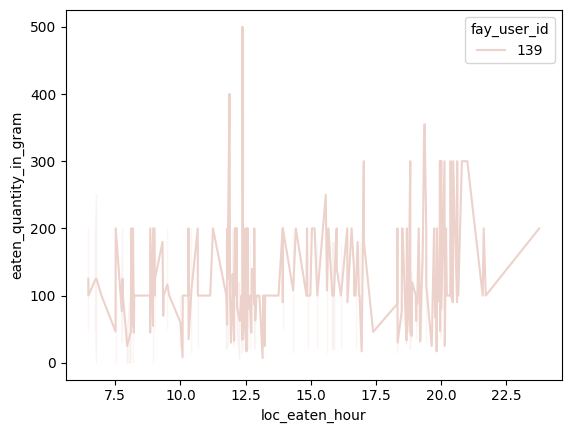

In [33]:
# sns.lineplot(slice, x="loc_eaten_hour", y="eaten_quantity_in_gram", hue="fay_user_id")

In [83]:
import pandas as pd
import numpy as np
from pandas.core.dtypes.dtypes import DatetimeTZDtype

GLUCOSE_TIMESERIES_GAP_SPLIT_THRESHOLD = pd.Timedelta(hours=2)
RESAMPLE_INTERVAL = "15min"

total_duplicate_count = 0

def interpolate_datetime_column(df, datetime_col, index_name):
    """
    Interpolates a datetime column 'datetime_col' in df, 
    using the DataFrame's DateTimeIndex in 'index_name' for time-based interpolation.
    """

    # If column doesn't exist or is entirely NaN, just return it
    if datetime_col not in df.columns:
        return df.get(datetime_col, pd.Series(index=df.index, dtype='datetime64[ns]'))

    s = df[datetime_col]

    # 1) If tz-aware, convert to UTC and remove tz
    #    (Check via isinstance(s.dtype, DatetimeTZDtype))
    if isinstance(s.dtype, DatetimeTZDtype):
        s = s.dt.tz_convert("UTC").dt.tz_localize(None)

    # 2) Convert non-null datetimes to int64, keep NaTs as NaN
    out = pd.Series(index=df.index, dtype="float")  # float so we can store numeric + NaN
    notna_mask = s.notna()

    # Instead of .view("int64"), use .astype("int64")
    out[notna_mask] = s[notna_mask].astype("int64").astype(float)

    # 3) Store this numeric representation in df, then .interpolate(method="time")
    df["__temp_numeric"] = out
    df["__temp_numeric"] = df["__temp_numeric"].interpolate(method="time")

    # 4) Convert back from float -> int -> datetime64
    df["__temp_numeric"] = df["__temp_numeric"].round().astype("Int64")  # can handle <NA>
    df["__temp_datetime"] = pd.to_datetime(df["__temp_numeric"], errors="coerce")

    # Clean up
    df.drop(columns=["__temp_numeric"], inplace=True)

    return df["__temp_datetime"]



def split_resample_15min_for_user(df_user):
    """
    Splits CGM data into blocks based on read_at gaps (>2h),
    resamples each block at 15-min intervals using read_at,
    interpolates val + loc_read_at.
    """

    global total_duplicate_count

    # Sort by device timestamp read_at
    df_user = df_user.sort_values("read_at")

    # Identify blocks: gap_indicator increments where gap>2h
    df_user["gap_indicator"] = (df_user["read_at"].diff() > GLUCOSE_TIMESERIES_GAP_SPLIT_THRESHOLD).cumsum()

    user_id = df_user["user_id"].iloc[0]
    cohort  = df_user["cohort"].iloc[0]

    blocks = []
    block_id = 0

    for _, block_df in df_user.groupby("gap_indicator"):
        # Check duplicates in read_at
        dup_mask = block_df["read_at"].duplicated(keep=False)
        if dup_mask.any():
            total_duplicate_count += dup_mask.sum()

        # Drop duplicates
        block_df = block_df.drop_duplicates(subset=["read_at"])

        # Set read_at as index
        block_df = block_df.set_index("read_at").sort_index()

        # Resample to 15-min frequency
        block_df = block_df.asfreq(RESAMPLE_INTERVAL)

        # Interpolate val
        block_df["val"] = block_df["val"].astype(float).interpolate(method="time")

        # Interpolate loc_read_at
        # We'll do the interpolation in place: 
        #  1) create block_df["loc_read_at"] if missing
        #  2) call interpolate_datetime_column
        if "loc_read_at" not in block_df.columns:
            block_df["loc_read_at"] = pd.NaT

        # The function needs the DataFrame to have a DateTimeIndex
        # so it can do method='time' interpolation
        block_df["loc_read_at"] = interpolate_datetime_column(block_df, "loc_read_at", index_name="read_at")
        # drop __temp_datetime column
        block_df.drop(columns=["__temp_datetime"], inplace=True)

        # Reassign user_id, cohort
        block_df["user_id"] = user_id
        block_df["cohort"]  = cohort

        # Mark block
        block_df["timeseries_block_id"] = f"{user_id}__{block_id}"
        block_id += 1

        blocks.append(block_df)

    # Concatenate all blocks for this user
    final_user_df = pd.concat(blocks)
    # Reset index so read_at becomes a column again
    final_user_df.reset_index(inplace=True)  # read_at is now a column
    return final_user_df

# Example usage:
user_groups = glucose_readings.groupby("user_id")
resampled_glucose_df = pd.concat(
    tqdm.tqdm([split_resample_15min_for_user(df) for _, df in user_groups]),
    ignore_index=True
)

print(f"[SUMMARY] Total duplicate read_at timestamps: {total_duplicate_count}")

# The resulting DataFrame has:
#   read_at (resampled timeline, every 15 mins),
#   loc_read_at (interpolated from original),
#   val (interpolated),
#   user_id, cohort, timeseries_block_id, etc.


100%|██████████| 1023/1023 [00:00<00:00, 1379669.77it/s]

[SUMMARY] Total duplicate read_at timestamps: 0


In [84]:
resampled_glucose_df

,read_at,user_id,cohort,val,loc_read_at,gap_indicator,timeseries_block_id
0,2018-11-26 08:00:00+00:00,5,B,6.06,2018-11-26 09:00:00,0.0,5__0
1,2018-11-26 08:15:00+00:00,5,B,7.55,2018-11-26 09:15:00,0.0,5__0
2,2018-11-26 08:30:00+00:00,5,B,8.51,2018-11-26 09:30:00,0.0,5__0
3,2018-11-26 08:45:00+00:00,5,B,7.39,2018-11-26 09:45:00,0.0,5__0
4,2018-11-26 09:00:00+00:00,5,B,6.80,2018-11-26 10:00:00,0.0,5__0
...,...,...,...,...,...,...,...
1483410,2023-02-12 22:44:00+00:00,2691,B,5.30,2023-02-12 21:14:00,NaN,2691__2
1483411,2023-02-12 22:59:00+00:00,2691,B,5.30,2023-02-12 21:14:00,NaN,2691__2
1483412,2023-02-12 23:14:00+00:00,2691,B,5.30,2023-02-12 21:14:00,NaN,2691__2
1483413,2023-02-12 23:29:00+00:00,2691,B,5.30,2023-02-12 21:14:00,NaN,2691__2


# Write data as CSV

In [162]:
# Write food data

In [85]:

VERSION="v0.1"
OUTPUT_DIRECTORY = f"data/processed/{VERSION}"

In [86]:
 # Write Food Intake data
completed_mfr_data.to_csv(os.path.join(OUTPUT_DIRECTORY, "food.csv"), index=True)

In [87]:
# Write glucose readings data
glucose_readings.to_csv(os.path.join(OUTPUT_DIRECTORY, "glucose.csv"), index=True)

resampled_glucose_df.to_csv(os.path.join(OUTPUT_DIRECTORY, "glucose_resampled.csv"), index=True)

# Merge Data 

In [1]:
import pandas as pd
import numpy as np 

VERSION="v0.1"
OUTPUT_DIRECTORY = f"data/processed/{VERSION}"

food_df = pd.read_csv(f"{OUTPUT_DIRECTORY}/food.csv", index_col=False)
resampled_glucose_df = pd.read_csv(f"{OUTPUT_DIRECTORY}/glucose_resampled.csv", index_col=False)


/tmp/ipykernel_3699208/959854653.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  food_df = pd.read_csv(f"{OUTPUT_DIRECTORY}/food.csv", index_col=False)


In [2]:
import tqdm



def merge_food_dish_cluster(df):
    
    # slice the food_df for the dish_id
    # df = food_df[food_df["dish_id"] == dish_id]
    
    assert df["eaten_at"].nunique() == 1
    _ROW = {}
    
    user_id = df["fay_user_id"].unique()[0]
    _ROW["user_id"] = user_id
    _ROW["food_intake_row"] = 1

    # Static values from all rows in the food cluster
    STATIC_VALUE_KEYS = ["eaten_at", "dish_id", "loc_eaten_hour", "loc_eaten_dow", "loc_eaten_dow_type", "loc_eaten_season"]
    for _key in STATIC_VALUE_KEYS:
        assert len(df[_key].unique()) == 1
        _ROW[_key] = df[_key].unique()[0]
        # TODO: Optimization opportunity

    df = df.fillna(0)

    # Nutritional values for food cluster
    AGGREGATE_AS_SUM_KEYS = ["eaten_quantity_in_gram", "energy_kcal_eaten", "carb_eaten", "fat_eaten", "protein_eaten", "fiber_eaten", "alcohol_eaten"]
    for _key in AGGREGATE_AS_SUM_KEYS:
        _ROW[_key] = float(df[_key].sum())
    
    # Add food groups as one-hot vectors
    ALL_FOOD_GROUPS = set(['vegetables_fruits', 'grains_potatoes_pulses', 'unclassified',
       'non_alcoholic_beverages', 'dairy_products_meat_fish_eggs_tofu',
       'sweets_salty_snacks_alcohol', 'oils_fats_nuts'])
    
    available_food_groups = set(df["food_group_cname"].unique())
    for _food_group_key in ALL_FOOD_GROUPS:
        _ROW[_food_group_key] = 1 if _food_group_key in available_food_groups else 0

    # Aggregated_metadata
    _ROW["mfr_row_ids"] = ",".join(str(x) for x in df.iloc[:,0].tolist()) # for the id from the mfr_data.csv file for future cross referencing
    _ROW["food_items"] = " && ".join(str(x) for x in df["display_name_en"].tolist()) # for the id from the mfr_data.csv file for future cross referencing
    
    return _ROW



# iterate over food_df grouped by dish_id apply merge_food_cluster
merged_dish_rows = []
for _dish_id, _df in tqdm.tqdm(food_df.groupby("dish_id")):
    merged_row_dict = merge_food_dish_cluster(_df)
    merged_dish_rows.append(merged_row_dict)
    
    
# merged_dish
# from p_tqdm import p_map
# merged_dish_rows = p_map(merge_food_dish_cluster, list(food_df["dish_id"].unique()), num_cpus=8)
# the parallelization sucks here ! 

  0%|          | 0/297626 [00:00<?, ?it/s]/tmp/ipykernel_3699208/1958170070.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
100%|██████████| 297626/297626 [05:55<00:00, 837.09it/s]


In [3]:
aggregated_food_df = pd.DataFrame(merged_dish_rows)
aggregated_food_df

,user_id,food_intake_row,eaten_at,dish_id,loc_eaten_hour,loc_eaten_dow,loc_eaten_dow_type,loc_eaten_season,eaten_quantity_in_gram,energy_kcal_eaten,...,alcohol_eaten,unclassified,sweets_salty_snacks_alcohol,non_alcoholic_beverages,dairy_products_meat_fish_eggs_tofu,grains_potatoes_pulses,oils_fats_nuts,vegetables_fruits,mfr_row_ids,food_items
0,9,1,2018-10-31 11:10:58+00:00,164,12.182778,Wed,weekday,Fall,420.0,603.20,...,0.0,1,0,1,0,1,0,0,"171206,323969,448465,449758","Bread, alpine && Water n.s. && Hummus && Greek..."
1,5,1,2018-10-31 11:31:50+00:00,165,12.530556,Wed,weekday,Fall,470.0,696.70,...,0.0,1,0,0,0,1,0,1,"21058,25196,49474,119717,156091,414973,446194",Coleslaw (chopped without sauce) && Mixed sala...
2,9,1,2018-10-31 13:12:41+00:00,169,14.211389,Wed,weekday,Fall,50.0,137.50,...,0.0,0,0,0,1,0,0,0,147441,Tiramisu
3,9,1,2018-10-31 12:05:28+00:00,170,13.091111,Wed,weekday,Fall,50.0,137.50,...,0.0,0,0,0,1,0,0,0,147442,Tiramisu
4,9,1,2018-10-31 14:42:51+00:00,172,15.714167,Wed,weekday,Fall,115.0,63.25,...,0.0,0,0,0,0,0,0,1,81795,Apple
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297621,2684,1,2023-03-26 17:37:47+00:00,428292,19.629722,Sun,weekend,Spring,220.0,589.60,...,0.0,1,0,0,0,0,0,0,477679,"French pizza from Alsace, baked"
297622,2684,1,2023-03-26 17:48:00+00:00,428295,19.800000,Sun,weekend,Spring,200.0,0.00,...,0.0,0,0,1,0,0,0,0,369856,Water n.s.
297623,2684,1,2023-03-26 19:54:45+00:00,428329,21.912500,Sun,weekend,Spring,225.0,323.10,...,0.0,0,1,0,1,0,0,0,"199416,497354","Crunch Müesli && Yaourt, yahourt, yogourt ou y..."
297624,2684,1,2023-03-26 19:54:00+00:00,428330,21.900000,Sun,weekend,Spring,200.0,0.00,...,0.0,0,0,1,0,0,0,0,382028,Water n.s.


# Align the food with the glucose data

In [4]:
import pandas as pd
import tqdm

resampled_glucose_df["read_at"] = pd.to_datetime(resampled_glucose_df["read_at"])
aggregated_food_df["eaten_at"] = pd.to_datetime(aggregated_food_df["eaten_at"])

FOOD_ALIGNMENT_TIME_WINDOW = pd.Timedelta(hours=2)  # allow for at most 2 hours of time difference

user_food_df_stacks = []
# For all user glucose threads
for user_id in tqdm.tqdm(resampled_glucose_df["user_id"].unique()):
    user_glucose_df = resampled_glucose_df[resampled_glucose_df["user_id"] == user_id]
    
    # Find all food clusters associated with this user
    user_food_df = aggregated_food_df[aggregated_food_df["user_id"] == user_id]
    
    # Filter out the food clusters that are not in the range of the glucose data
    valid_mask = (
        (user_food_df["eaten_at"] >= user_glucose_df["read_at"].min()) & 
        (user_food_df["eaten_at"] <= user_glucose_df["read_at"].max())
    )
    user_food_df = user_food_df[valid_mask].copy()
    
    # Iterate over all the food clusters and find the closest match in the user glucose table
    aligned_eaten_at_values = []
    original_eaten_at_values = []
    for idx in range(len(user_food_df)):
        user_food_row = user_food_df.iloc[idx]
        eaten_time = user_food_row["eaten_at"]
        
        # Add the original eaten time to the list
        original_eaten_at_values.append(eaten_time)
        
        # Find index of the closest glucose time to this food eaten time
        closest_glucose_idx = (user_glucose_df["read_at"] - eaten_time).abs().idxmin()
        closest_glucose_time = user_glucose_df.loc[closest_glucose_idx, "read_at"]
        
        # Check if the time difference is within the FOOD_ALIGNMENT_TIME_WINDOW
        time_diff = abs(closest_glucose_time - eaten_time)
        if time_diff <= FOOD_ALIGNMENT_TIME_WINDOW:
            aligned_eaten_at_values.append(closest_glucose_time)
        else:
            # Option A: Append NaT to indicate no valid alignment found
            aligned_eaten_at_values.append(pd.NaT)
            # Option B: You could also skip it or handle it differently if desired:
            # aligned_eaten_at_values.append(None)
            # (then drop these rows later if needed)
    
    user_food_df["aligned_eaten_at"] = aligned_eaten_at_values
    user_food_df["original_eaten_at"] = original_eaten_at_values
    # If you want to drop rows that have no valid alignment (NaT):
    user_food_df = user_food_df.dropna(subset=["aligned_eaten_at"])
    
    user_food_df_stacks.append(user_food_df)
    
    # break  # remove this once you confirm logic is correct for all users

# user_food_df_stacks


100%|██████████| 1023/1023 [01:04<00:00, 15.83it/s]


In [5]:
# Concatenate all the user food dataframes into a single one
aligned_food_df = pd.concat(user_food_df_stacks)
aligned_food_df

/tmp/ipykernel_3699208/2324549463.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aligned_food_df = pd.concat(user_food_df_stacks)


,user_id,food_intake_row,eaten_at,dish_id,loc_eaten_hour,loc_eaten_dow,loc_eaten_dow_type,loc_eaten_season,eaten_quantity_in_gram,energy_kcal_eaten,...,unclassified,sweets_salty_snacks_alcohol,non_alcoholic_beverages,dairy_products_meat_fish_eggs_tofu,grains_potatoes_pulses,oils_fats_nuts,vegetables_fruits,mfr_row_ids,food_items,aligned_eaten_at
200,5,1,2018-11-26 08:56:24+00:00,822,9.940000,Mon,weekday,Fall,100.0,95.0,...,0,0,0,0,0,0,1,87060,Banana,2018-11-26 09:00:00+00:00
201,5,1,2018-11-26 10:37:26+00:00,826,11.623889,Mon,weekday,Fall,200.0,225.6,...,0,0,0,0,1,1,1,"21772,157979,228051","Mixed vegetables && Rice && Oil, olive (Olive ...",2018-11-26 10:30:00+00:00
202,5,1,2018-11-26 10:37:36+00:00,827,11.626667,Mon,weekday,Fall,110.0,197.1,...,1,0,0,0,0,0,1,"25199,422257",Mixed salad (chopped without sauce) && Balsami...,2018-11-26 10:45:00+00:00
203,5,1,2018-11-26 10:57:39+00:00,828,11.960833,Mon,weekday,Fall,50.0,116.0,...,0,0,0,0,1,0,0,171202,"Bread, alpine",2018-11-26 11:00:00+00:00
204,5,1,2018-11-26 10:57:45+00:00,829,11.962500,Mon,weekday,Fall,50.0,116.0,...,0,0,0,0,1,0,0,171203,"Bread, alpine",2018-11-26 11:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295345,2691,1,2023-02-11 10:07:40+00:00,420009,11.127778,Sat,weekend,Winter,300.0,0.0,...,0,0,1,0,0,0,0,382101,Water n.s.,2023-02-11 10:13:00+00:00
295352,2691,1,2023-02-12 06:43:15+00:00,420072,7.720833,Sun,weekend,Winter,340.0,582.0,...,0,0,0,0,1,0,1,"40495,171184","Avocado && Bread, 5-grain",2023-02-12 05:58:00+00:00
295353,2691,1,2023-02-12 06:56:05+00:00,420073,7.934722,Sun,weekend,Winter,20.0,49.8,...,0,1,0,0,0,0,0,248439,Jam,2023-02-12 05:58:00+00:00
295354,2691,1,2023-02-12 06:56:42+00:00,420074,7.945000,Sun,weekend,Winter,100.0,2.0,...,0,0,1,0,0,0,0,289220,"Espresso, with caffeine",2023-02-12 05:58:00+00:00


## Merge food rows in the same time window

In [6]:
# Merge food rows in the same time window

def merge_food_clusters_for_same_time_window(df):
    """
    TODO: This is a duplicate function, and should be refactored to a single function that can 
    be used above as well.
    """
    if len(df) == 1:
        return df
    
    assert df["aligned_eaten_at"].nunique() == 1
    _ROW = {}
    
    user_id = df["user_id"].unique()[0]
    _ROW["user_id"] = user_id
    _ROW["aligned_eaten_at"] = df["aligned_eaten_at"].unique()[0]
    _ROW["food_intake_row"] = 1

    # Mean values from all rows in the food cluster
    MEAN_VALUE_KEYS = ["eaten_at", "loc_eaten_hour"] # , "loc_eaten_dow", "loc_eaten_dow_type", "loc_eaten_season"]
    for _key in MEAN_VALUE_KEYS:
        _ROW[_key] = df[_key].mean()
        # TODO: Optimization opportunity

    # Static Values that need to be copied over
    # Static values from all rows in the food cluster
    STATIC_VALUE_KEYS = ["loc_eaten_dow", "loc_eaten_dow_type", "loc_eaten_season"]
    for _key in STATIC_VALUE_KEYS:
        # assert len(df[_key].unique()) == 1
        # TODO: This needs a re-check as to, how to cluster items in the same time window but different classes.
        _ROW[_key] = df[_key].unique()[0]
        # TODO: Optimization opportunity

    _ROW["dish_id"] = "||".join([str(x) for x in df["dish_id"]])
    
    # Nutritional values for food cluster
    AGGREGATE_AS_SUM_KEYS = ["eaten_quantity_in_gram", "energy_kcal_eaten", "carb_eaten", "fat_eaten", "protein_eaten", "fiber_eaten", "alcohol_eaten"]
    for _key in AGGREGATE_AS_SUM_KEYS:
        _ROW[_key] = df[_key].sum()
    
    # Add food groups as one-hot vectors
    ALL_FOOD_GROUPS = set(['vegetables_fruits', 'grains_potatoes_pulses', 'unclassified',
       'non_alcoholic_beverages', 'dairy_products_meat_fish_eggs_tofu',
       'sweets_salty_snacks_alcohol', 'oils_fats_nuts'])
    
    for _food_group_key in ALL_FOOD_GROUPS:
        _ROW[_food_group_key] = int(df[_food_group_key].any())

    # Aggregated_metadata
    _ROW["mfr_row_ids"] = ",".join(str(x) for x in df["mfr_row_ids"].tolist()) # for the id from the mfr_data.csv file for future cross referencing
    _ROW["food_items"] = " && ".join(str(x) for x in df["food_items"].tolist()) # for the id from the mfr_data.csv file for future cross referencing
    # display(_ROW)
    return pd.DataFrame([_ROW])
        

user_food_df_stacks_time_window_merged = []
aligned_window_food_groups = aligned_food_df.groupby(["aligned_eaten_at", "user_id"])
for name, food_group in tqdm.tqdm(aligned_window_food_groups):
    user_food_df_stacks_time_window_merged.append(merge_food_clusters_for_same_time_window(food_group))

100%|██████████| 164478/164478 [02:19<00:00, 1176.00it/s]


In [7]:
len(user_food_df_stacks_time_window_merged)

164478

In [8]:
aligned_food_df = pd.concat(user_food_df_stacks_time_window_merged)

: 

# Merged Glucose and Food Data

In [1]:
merged_PPGR_data = resampled_glucose_df.merge(aligned_food_df, left_on = ['read_at', 'user_id'], right_on=['aligned_eaten_at', 'user_id'], how = 'left')
merged_PPGR_data

NameError: name 'resampled_glucose_df' is not defined

In [ ]:
# Sanity Check assertion
assert len(merged_PPGR_data) == len(resampled_glucose_df), "The merged (and aligned) food df should have the same number of rows as the glucose data, as we are aligning the food data to the timesteps of the glucose data"

In [ ]:
# Basic Cleanup of the Dataframe before export

# Drop the Unnamed column
if "Unnamed: 0" in merged_PPGR_data.columns:
    merged_PPGR_data = merged_PPGR_data.drop(columns=["Unnamed: 0"])

# Set food_intake_row default as 0
merged_PPGR_data["food_intake_row"] = merged_PPGR_data["food_intake_row"].fillna(0)

# Setup nutrional data default value as 0
nutrition_data_columns = ["eaten_quantity_in_gram", "energy_kcal_eaten", "carb_eaten", "fat_eaten", "protein_eaten", "fiber_eaten", "alcohol_eaten"]
merged_PPGR_data[nutrition_data_columns] = merged_PPGR_data[nutrition_data_columns].fillna(0)

# Setup food group one hot vector default value as 0
food_group_column_names = ['vegetables_fruits', 'grains_potatoes_pulses', 'unclassified',
       'non_alcoholic_beverages', 'dairy_products_meat_fish_eggs_tofu',
       'sweets_salty_snacks_alcohol', 'oils_fats_nuts']
merged_PPGR_data[food_group_column_names] = merged_PPGR_data[food_group_column_names].fillna(0)

# Add the loc_eaten_* params correctly
merged_PPGR_data["loc_read_at"] = pd.to_datetime(merged_PPGR_data["loc_read_at"], format="mixed")

merged_PPGR_data["loc_eaten_hour"] = (
    merged_PPGR_data["loc_read_at"].dt.hour +
    merged_PPGR_data["loc_read_at"].dt.minute / 60 +
    merged_PPGR_data["loc_read_at"].dt.second / 3600
) # Note this updates the more accurate values for the food intake fields - but we can revisit this later

# Add DOW
merged_PPGR_data["loc_eaten_dow"] = merged_PPGR_data["loc_read_at"].dt.day_name().str[:3]

# Add DOW Type
merged_PPGR_data["loc_eaten_dow_type"] = np.where(
    merged_PPGR_data["loc_read_at"].dt.dayofweek < 5,
    "weekday",
    "weekend"
)

# add season column (meteorological, not astronomical)
season_months = np.array(range(12)) + 1
season_names = ["Winter"] * 3 + ["Spring"] * 3 + ["Summer"] * 3 + ["Fall"] * 3
season_map = dict(zip(season_months, np.roll(season_names, -1)))
merged_PPGR_data["loc_eaten_season"] = merged_PPGR_data["loc_read_at"].dt.month.map(season_map)



In [ ]:
output_path = os.path.join(OUTPUT_DIRECTORY, f"fay-ppgr-processed-and-aggregated-{VERSION}.csv")
merged_PPGR_data.to_csv(output_path, index=False)

print(f"Merged PPGR saved to : {output_path}")

In [ ]:
merged_PPGR_data.describe()

In [ ]:
merged_PPGR_data

## Dev Dataset 

In [ ]:
users = sorted(merged_PPGR_data["user_id"].unique())
dev_users = users[:10]

dev_merged_PPGR_data = merged_PPGR_data[merged_PPGR_data["user_id"].isin(dev_users)]
dev_merged_PPGR_data.to_csv(os.path.join(OUTPUT_DIRECTORY, f"fay-ppgr-processed-and-aggregated-{VERSION}-dev.csv"), index=False)

print(f"Dev Merged PPGR saved to : {os.path.join(OUTPUT_DIRECTORY, f'fay-ppgr-processed-and-aggregated-{VERSION}-dev.csv')}")
